# Application geochemical modeller position University of Antwerpen

*Martin Schobben* 

## Original exercise 

In a reactor, 1kg of basalt is dissolved in 1000 l deionized water (pH 7). The temperature is 25 ⁰C and atmospheric CO2 partial pressure is 2bar. The experiment is performed for 2 types of basalt (separately). Composition of the basalt1: 5%fosterite, 50% Ca plagioclase endmember and 45% augite (mass %). Composition of the basalt2  is 15%fosterite , 35% labradorite and 50% augite (mass %). The specific surface area (SSA) of basalt1 is 5 m²/g; SSA of basalt2 is 1 m²/g.

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import phreeqpython as ph
import math
import chemw
import os
from scipy.integrate import odeint

## Boundary conditions

I first fix all the boundary conditions of the exercise. For this a PhreeqPython session is initiated.

In [19]:
# start session
pp = ph.PhreeqPython(os.path.join(os.getcwd(), 'database', 'T_H.DAT'))

# boundary conditions mediuum
volume = 1000 # l
pH = 7
Temp = 25 # degree Celcius
pCO2 = 2 # bar
logCO2 = math.log10(pCO2)

# boundary conditions reactant
mass_basalt = 1000 # g
# specific surface area 
ssa1 = 5 # cm2 / g
ssa2 = 1 # cm2 / g

After that I instantiate two solutions for both of the basalt experiment, and ensure that these solutions are in equilibrium with atmospheric $pCO_{2}$. To check the result I show the output of solution 1 before and after equalizing the solution.

In [20]:
# initiate solution 1 (pH = 7 and T = 25 C)
solution1 = pp.add_solution({})
# check alkalinity
solution1.total('HCO3-', 'mol')  + 2 * solution1.total('CO3-', 'mol')

0.0

In [21]:
# CO2 in equilibrium
solution1 = solution1.equalize(['CO2(g)'], [logCO2])
# check alkalinity
solution1.total('HCO3-', 'mol')  + 2 * solution1.total('CO3-', 'mol')

0.00017657538415155082

In [22]:
# initiate solution 2
solution2 = pp.add_solution({})
# CO2 in equilibrium
solution2 = solution2.equalize(['CO2(g)'], [logCO2])

After that I keep the the overhead pressure constant, as follows:

In [23]:
# keep gas at fixed pressure
fp = pp.add_gas({'CO2(g)': 0,}, pressure=pCO2, fixed_pressure=True)
solution1.interact(fp.copy())
solution2.interact(fp.copy())

## State variables

Here I define the state variable (chemical species) that change over time with the correct units. For molecular weights I use the *chemw* package.

In [24]:
# get molecular weights
chem_mw = chemw.ChemMW(verbose = False, printing = True)

# mineral fractions basalt1
frac_for1 = 0.05
mass_for1 =  mass_basalt * frac_for1 # g
frac_plag1 = 0.5
mass_plag1 = mass_basalt * frac_plag1 # g
frac_diop1 = 0.45
mass_diop1 = mass_basalt * frac_diop1 # g

# mineral fractions basalt2
frac_for2 = 0.15
mass_for2 =  mass_basalt * frac_for2 # g
frac_plag2 = 0.35
mass_plag2 = mass_basalt * frac_plag2 # g
frac_diop2 = 0.5
mass_diop2 = mass_basalt * frac_diop2 # g

# Olivine (Forsterite = Mg2SiO4 + 4H+ = 2Mg+2 + H4SiO4)
name_for = 'Forsterite'
formula_for = 'Mg2SiO4'
amu_for = chem_mw.mass(formula_for)
dens_for = 3.32 # g mineral per cm3 mineral

# basalt 1
M0_for1 = mass_for1 / float(amu_for) # mol

# basalt 2
M0_for2 = mass_for2 / float(amu_for) # mol

# Plagioclase (Anorthite = CaAl2Si2O8 + 8H2O = Ca+2 + 2Al(OH)4- + 2H4SiO4)
name_plag = 'Anorthite'
formula_plag = 'CaAl2Si2O8' 
amu_plag = chem_mw.mass(formula_plag)
dens_plag = 2.73 # g mineral per cm3 mineral

# basalt 1
M0_plag1 = mass_plag1 / float(amu_plag) # mol 

# basalt 2
M0_plag2 = mass_plag2 / float(amu_plag) # mol 

# Diopside (Augite = CaMgSi2O6 + 4H+ + 2H2O = Ca+2 + Mg+2 + 2H4SiO4)
name_diop = 'Diposide'
formula_diop = 'CaMgSi2O6'
amu_diop = chem_mw.mass(formula_diop)
dens_diop = 3.4 # g mineral per cm3 mineral

# basalt 1
M0_diop1 = mass_diop1 / float(amu_diop) # mol

# basalt 2
M0_diop2 = mass_diop2 / float(amu_diop) # mol

Mg2SiO4 --- MW (amu): 140.69
CaAl2Si2O8 --- MW (amu): 278.21
CaMgSi2O6 --- MW (amu): 216.55


## Calculate mineral specific surface area

Here I define a function which inputs the rock mineral masses and denisties togeter with the rock's overall surface area in order to obtain the mineral specific surface area in ,m2. By first calculating the volume fraction of each mineral, as follows:

$$ \text{f}V_{i} = M_{i} * \rho_i / \sum_{i=1}^{N} M_{i} * \rho_i .$$

This step is followed by calculating the relative specific surface area (RSSA) with the mineral's volume fraction, as follows:

$$ \text{f}V_{i} = \text{f}V_{i}^{(\frac{2}{3})} / \sum_{i=1}^{N} \text{f}V_{i}^{(\frac{2}{3})} .$$

To obtain the mineral's $i$ surface area the RSSA is multiplied with the rock's total SSA and the mineral specific masses:

$$ A_{i} = RSSA * SSA * M_{i} $$

In [25]:
# Mineral specific surface area
def calc_surface(mass, dens, total_ssa):
    """ 
    Parameters
    ------------
    mass = array of mineral masses in grams
    dens = array of mineral densities in gram per cm3 
    total_ssa = specific surface area of total rock (cm2 / g)

    Description
    ---------------
    Use volume fractions to caclculate relative SSA (RSSA) for 
    each of the minerals of the rock.

    SSA_mineral (cm2 / g) = RSSA_mineral * SSA_tot (cm2 / g)
    A_mineral = mass_mineral * SSA_mineral

    Output
    -------
    initial surface of mineral m2
    
    """
    
    # initialise arrays
    vol_frac = np.array([])
    rssa = np.array([])
    
    # calculate volume fraction
    tot_vol_frac = mass * dens # volume fraction
    for i in range(len(mass)):
        vol_frac = np.append(vol_frac, (mass[i] * dens[i]) / tot_vol_frac.sum())

    # calculate relative ssa
    tot_rssa = vol_frac ** (2 / 3)
    for i in range(len(vol_frac)):
        rssa = np.append(rssa, (vol_frac[i]  ** (2 / 3)) / tot_rssa.sum()) 

    return tuple(rssa * total_ssa *  mass)

# arrays of masses 
mass1 = np.array([mass_for1, mass_plag1, mass_diop1])
mass2 = np.array([mass_for2, mass_plag2, mass_diop2])
# arrays of densities
dens = np.array([dens_for, dens_plag, dens_diop])
# mineral specific surface area
A_for1, A_plag1, A_diop1 = calc_surface(mass1, dens, ssa1) # basalt 1
A_for2, A_plag2, A_diop2 = calc_surface(mass2, dens, ssa2) # basalt 2

## Kinetic dissolution of a mineral

Here I define the function for kinetic dissolution of the mineral phases within the rock sample. This function is defined as follows:

$$ \frac{dS_i}{dt}  = \frac{A_0}{V} \frac{M}{M_0}^{0.67} k (1 - SR) $$

where $Si$ is the concentration of species $i$ (mol/L); $t$ is time (s); $A0$ is the initial surface of the mineral phase (m2); $V$ is the solution volume (L); $M$ is the remaining mass of phase $i$ (moles); $M0$ is the initial mass of species $i$ (moles); $k$ is the rate constant = 10-13.7 mol/m2/s (25 C); SR is the Saturation Ratio for species $i$.

In [26]:
# kinetic dissolution
def ratefun(dm, time, sol, form, phase, m0, A0, V, kfun):
    """ 
    parameters
    --------
    sol = The solution at timestep t
    dm = difference in moles of for timestep dt
    m0 = Moles of initial phase
    A0 = Initial surface m2 (calculate with mineral specific surface)
    V = Volume in liters
    phase = String of phase name
    form = stochiometry phase
    kfun = function to calculate rate constant

    other params
    ---------
    k rate constant
    SR is the Saturation Ratio for the phase

    Output
    --------
    Dissolution rate mol/liter/sec
    """
    # save intermediate
    temp = sol.copy()

    # add to solution
    temp.add(form, dm[0], "mol")

    # moles of phase for timestep t
    m = m0 - dm[0]
    
    # rate constant
    k = kfun(temp)

    # rate at timestep t
    if sol.sr(phase) < 0 or m >= 0:
        rate = (A0 / V) * (m / m0) ** 0.67 * k * (1 - sol.sr(phase))
    else:
        rate = 0
    
    temp.forget() # cleanup the no longer needed temporary solution
    return rate

In order to calculate the dissolution constants $R$ which depend on $T$ and ${H+}$, the following equation is followed.

$$ r_{acid} = k_{acid}^{298.15K} \exp{\frac{-E_{acid}}{R}(\frac{1}{T} - \frac{1}{298.15K})} a_{\text{H}^+} $$
$$ r_{neutral} = k_{neutral}^{298.15K} \exp{\frac{-E_{neutral}}{R}(\frac{1}{T} - \frac{1}{298.15K})} $$
$$ r_{base} = k_{base}^{298.15K} \exp{\frac{-E_{base}}{R}(\frac{1}{T} - \frac{1}{298.15K})} a_{\text{H}^+} $$

with the gas constant $R$, activation energy $E$ following the paper by Kelland et al 2020. Although it seems that they use the wrong units for denoting the gas constant in the SI of the paper. 

And I cast these into a function factory, as follows:

In [27]:
def calc_rate_const(k_acid, eapp_acid, n_acid, k_neut, eapp_neut, k_base, eapp_base, n_base):
    def rate_const(sol) :
        """ 
        R = gas constant 8.314e-3 J / K / mol 1.987 cal / mol * K
        eapp activation energy (Kj/mol) 
        T = K
        k = moles/m2/s
        n = acitivity 

        """
        temp = sol.copy()
        dif_temp = 1 / temp.temperature - 1 / 298.15
        hplus = temp.total("H+", 'mol')

        r_acid = k_acid * math.exp((-eapp_acid / 8.314) * dif_temp) * (hplus ** n_acid)
        r_neut = k_neut * math.exp((-eapp_neut / 8.314) * dif_temp)
        r_base = k_base * math.exp((-eapp_base / 8.314) * dif_temp) * (hplus ** n_base)
    
        return r_acid + r_neut + r_base
    return rate_const

# function to calculate rate constant diopside
k_diop = calc_rate_const(k_acid = 10 ** -6.36, eapp_acid = 96.1, n_acid = 0.71,  k_neut = 10 ** -11.11, eapp_neut = 40.6, k_base = 0, eapp_base = 0,  n_base = 0)
k_for = calc_rate_const(k_acid = 10 ** -6.85, eapp_acid = 67.2, n_acid = 0.74,  k_neut = 10 ** -10.64, eapp_neut = 79, k_base = 0, eapp_base = 0,  n_base = 0)
k_plag = calc_rate_const(k_acid = 10 ** -7.87, eapp_acid = 42.1, n_acid = 0.626,  k_neut = 10 ** -10.91, eapp_neut = 45.2, k_base = 0, eapp_base = 0,  n_base = 0)

The following function solves the previous defined ordinary differential equation.

In [28]:
# solve ODE 
def solve_kinetic(sol, time, form, phase, m0, A0, V, kfun):

    # integrate
    yy = odeint(ratefun, 0, time, args=(sol, form, phase, m0, A0, V, kfun))
    dif_yy = np.insert(np.diff(yy[:,0]), 0, 0)

    # impact on alkalinity
    alk = []
    for i in range(len(time)):
        t = tt[i]
        sol.add(form, dif_yy[i])
        alk.append(sol.total('HCO3-', 'mmol')  + 2 * sol.total('CO3-', 'mmol'))

    return np.array(alk), yy[:,0]

# seconds in week
weeks = 7 * 24 * 3600
nmax = 2 # weeks
tt = np.linspace(0, nmax * weeks, 25)

# solve differential equation basalt1
# add forsterite
y_for1, M_for1 = solve_kinetic(solution1, tt, formula_for, name_for, M0_for1, A_for1, volume, k_for)

# add ca plagioclase
y_plag1, M_plag1 = solve_kinetic(solution1, tt, formula_plag, name_plag, M0_plag1, A_plag1, volume, k_plag)

# add diopside
y_diop1, M_diop1 = solve_kinetic(solution1, tt, formula_diop, name_diop, M0_diop1, A_diop1, volume, k_diop)

# solve differential equation basalt2
# add forsterite
y_for2, M_for2 = solve_kinetic(solution2, tt, formula_for, name_for, M0_for2, A_for2, volume, k_for)

# add ca plagioclase
y_plag2, M_plag2 = solve_kinetic(solution2, tt, formula_plag, name_plag, M0_plag2, A_plag2, volume, k_plag)

# add diopside
y_diop2, M_diop2 = solve_kinetic(solution2, tt, formula_diop, name_diop, M0_diop2, A_diop2, volume, k_diop)

## Question 1

*What will be the alkalinity after two weeks?*

I have used carbonate alkalinity as a measure for alkalinity and I plot the results of the solution for both basalts as a timeseries of two weeks.

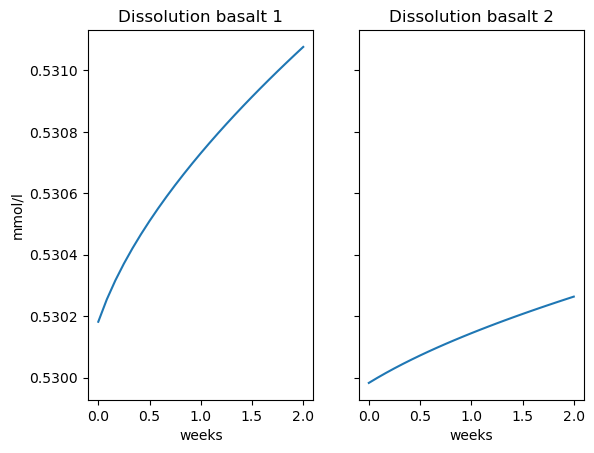

In [29]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(tt / weeks, y_diop1 + y_plag1 + y_for1, label = 'Alkalinity')
ax2.plot(tt / weeks, y_diop2 + y_plag2 + y_for2, label = 'Alkalinity')

# decoration
ax1.set_xlabel('weeks')
ax2.set_xlabel('weeks')
ax1.set_ylabel('mmol/l')
ax1.set_title('Dissolution basalt 1')
ax2.set_title('Dissolution basalt 2')
plt.show()

To better show what the difference is I plot the differenc of the start of the experiment with the concentration after two week for both experimetns. This shows that basalt 1 increases the solution with about 5 mmol/liter alkalinity and basalt 2 only 1 mmol/liter alkalinity.

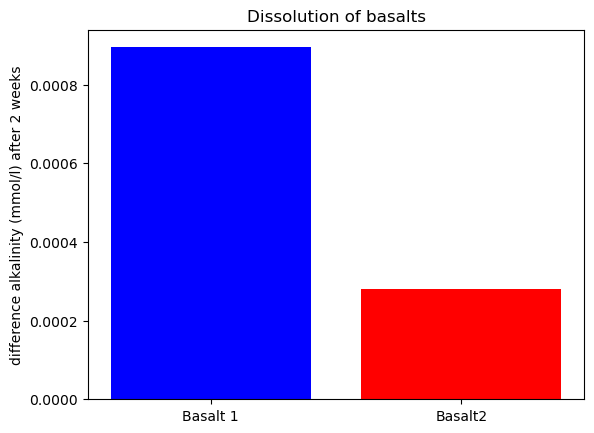

In [30]:
# bar plot of difference
fig, ax = plt.subplots()

# difference in alkalinity over two weeks
diff1 = (y_diop1[-1] + y_for1[-1] + y_plag1[-1]) - (y_diop1[0] + y_for1[0] + y_plag1[0])
diff2 = (y_diop2[-1] + y_for2[-1] + y_plag2[-1]) - (y_diop2[0] + y_for2[0] + y_plag2[0])
diffs = [diff1, diff2]
names = ['Basalt 1', 'Basalt2']

# barplot 
ax.bar(names, diffs, label=names, color=['blue', 'red'])
ax.set_ylabel('difference alkalinity (mmol/l) after 2 weeks')
ax.set_title('Dissolution of basalts')

plt.show()

## Question 2

*Which of the 2 basalts will sequester more CO2 during this time period? *

This result suggest that weathering of basalt 1 would be most efficient in drawing down atmospheric $p\text{CO}_2$.


## Question 3

*How long will it take to dissolve 99% of basalt 1 and 2 respectively?*

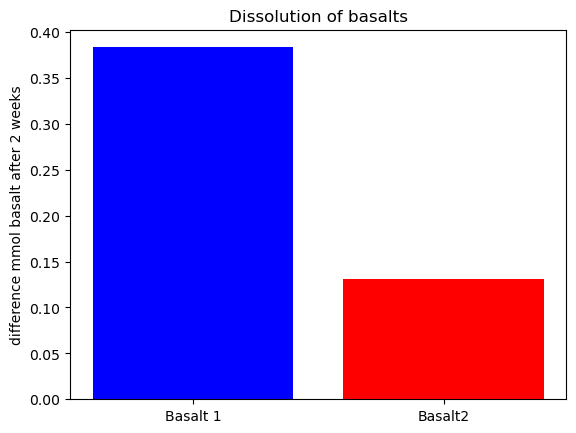

In [33]:
# bar plot of difference
fig, ax = plt.subplots()

# difference in alkalinity over two weeks
diff1 = (M_diop1[-1] + M_for1[-1] + M_plag1[-1]) - (M_diop1[0] + M_for1[0] + M_plag1[0]) 
diff2 = (M_diop2[-1] + M_for2[-1] + M_plag2[-1]) - (M_diop2[0] + M_for2[0] + M_plag2[0])
diffs = [diff1 * 1e3, diff2 * 1e3]
names = ['Basalt 1', 'Basalt2']

# barplot 
ax.bar(names, diffs, label=names, color=['blue', 'red'])
ax.set_ylabel('difference mmol basalt after 2 weeks')
ax.set_title('Dissolution of basalts')

plt.show()

About 0.38 mmol (from 4230 mmol) and 0.13 mmol (from 4633 mmol) have dissolved of the basalt 1 and 2, respectively. At this rate it will take

In [39]:
dec1 = math.log((4320 - 0.38) / 4230, 0.5)
#(2 / 52) / 
dec1

-2.0860439562919546